In [21]:
import os
import string
import numpy as np
import pandas as pd
from pandasql import sqldf

import matplotlib.pyplot as plt

from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential, model_from_json
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers import Input, Dense, Dropout, Flatten, Lambda, Embedding
from keras.initializers import RandomNormal, Constant
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import regularizers
from keras import backend as K
import tensorflow as tf

from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import seaborn as sns
import warnings

from math import sqrt

import itertools
from tqdm import tqdm

np.random.seed(42)  # for reproducibility

sns.set(style="whitegrid", color_codes=True)
sns.set(font_scale=1)

pd.set_option('display.max_columns', 60)

%matplotlib inline
warnings.filterwarnings('ignore')

## Analisys Exploratory

In [22]:
def concat_data():
    df_train = pd.read_csv('../input/train.csv')
    df_test = pd.read_csv('../input/test.csv')
    df_extra = pd.read_csv('../input/store.csv')
    df_test['Sales'] = -1
    df_full = pd.concat([df_train, df_test]).reset_index(drop=True)

    #Merge extra information about stores
    df_full = df_full.merge(df_extra, left_on=['Store'], right_on=['Store'], how='left')
    
    df_full['Year'] = pd.DatetimeIndex(df_full['Date']).year
    df_full['Month'] = pd.DatetimeIndex(df_full['Date']).month
    df_full['Day'] = pd.DatetimeIndex(df_full['Date']).day
    df_full['WeekOfYear'] = pd.DatetimeIndex(df_full['Date']).weekofyear
    
    # Calculate competition open in months
    df_full['CompetitionOpen'] = 12 * (df_full.Year - df_full.CompetitionOpenSinceYear) + \
        (df_full.Month - df_full.CompetitionOpenSinceMonth)

    # Calculate promo open time in months
    df_full['PromoOpen'] = 12 * (df_full.Year - df_full.Promo2SinceYear) + \
        (df_full.WeekOfYear - df_full.Promo2SinceWeek) / 4.0
    df_full['PromoOpen'] = df_full.PromoOpen.apply(lambda x: x if x > 0 else 0)
    df_full.loc[df_full.Promo2SinceYear == 0, 'PromoOpen'] = 0

    # Transform month interval in a boolean column 
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    df_full['monthStr'] = df_full.Month.map(month2str)
    df_full.loc[df_full.PromoInterval == 0, 'PromoInterval'] = ''
    df_full['IsPromoMonth'] = 0
    for interval in df_full.PromoInterval.unique():
        interval = str(interval)
        if interval != '':
            for month in interval.split(','):
                df_full.loc[(df_full.monthStr == month) & (df_full.PromoInterval == interval), 'IsPromoMonth'] = 1


    return df_full

df_full = concat_data()

In [23]:
def extrat_test_data(df_full):
    df_train = df_full.loc[df_full['Sales'] != -1]
    df_test = df_full.loc[df_full['Sales'] == -1]

    return df_train, df_test

df_train, df_test = extrat_test_data(df_full)

In [24]:
df_full.head()

,Customers,Date,DayOfWeek,Id,Open,Promo,Sales,SchoolHoliday,StateHoliday,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval,Year,Month,Day,WeekOfYear,CompetitionOpen,PromoOpen,monthStr,IsPromoMonth
0,555.0,2015-07-31,5,NaN,1.0,1,5263,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN,2015,7,31,31,82.0,0.00,Jul,0
1,625.0,2015-07-31,5,NaN,1.0,1,6064,1,0,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct",2015,7,31,31,92.0,64.50,Jul,1
2,821.0,2015-07-31,5,NaN,1.0,1,8314,1,0,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct",2015,7,31,31,103.0,52.25,Jul,1
3,1498.0,2015-07-31,5,NaN,1.0,1,13995,1,0,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN,2015,7,31,31,70.0,0.00,Jul,0
4,559.0,2015-07-31,5,NaN,1.0,1,4822,1,0,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN,2015,7,31,31,3.0,0.00,Jul,0


**Missing Values**

In [25]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 0 to 1058296
Data columns (total 27 columns):
Customers                    1017209 non-null float64
Date                         1058297 non-null object
DayOfWeek                    1058297 non-null int64
Id                           41088 non-null float64
Open                         1058286 non-null float64
Promo                        1058297 non-null int64
Sales                        1058297 non-null int64
SchoolHoliday                1058297 non-null int64
StateHoliday                 1058297 non-null object
Store                        1058297 non-null int64
StoreType                    1058297 non-null object
Assortment                   1058297 non-null object
CompetitionDistance          1055559 non-null float64
CompetitionOpenSinceMonth    719733 non-null float64
CompetitionOpenSinceYear     719733 non-null float64
Promo2                       1058297 non-null int64
Promo2SinceWeek              533034 non-nul

In [26]:
# Function to calculate missing values by column (By DSA)
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

missing_values_table(df_full)

Your selected dataframe has 27 columns.
There are 10 columns that have missing values.


,Missing Values,% of Total Values
Id,1017209,96.1
Promo2SinceWeek,525263,49.6
Promo2SinceYear,525263,49.6
PromoInterval,525263,49.6
CompetitionOpenSinceMonth,338564,32.0
CompetitionOpenSinceYear,338564,32.0
CompetitionOpen,338564,32.0
Customers,41088,3.9
CompetitionDistance,2738,0.3
Open,11,0.0


In [27]:
df_full.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,573755.0,5516.836857,4040.894806,-1.0,3069.0,5467.0,7745.00,41551.0
b,16406.0,9705.645435,5507.579042,-1.0,5943.0,8804.5,12888.75,38722.0
c,141112.0,5550.322822,3793.918390,-1.0,3498.0,5662.0,7770.00,31448.0
d,327024.0,5398.315815,3585.889475,-1.0,3566.0,5679.0,7591.00,38037.0


In [28]:
df_full.groupby('StoreType')['Customers', 'Sales'].sum()

,Customers,Sales
StoreType,,
a,363541434.0,3165312731
b,31465621.0,159230819
c,92129705.0,783217154
d,156904995.0,1765378831


Text(0.5, 1.0, 'Correlation Coefficients w.r.t Sales')

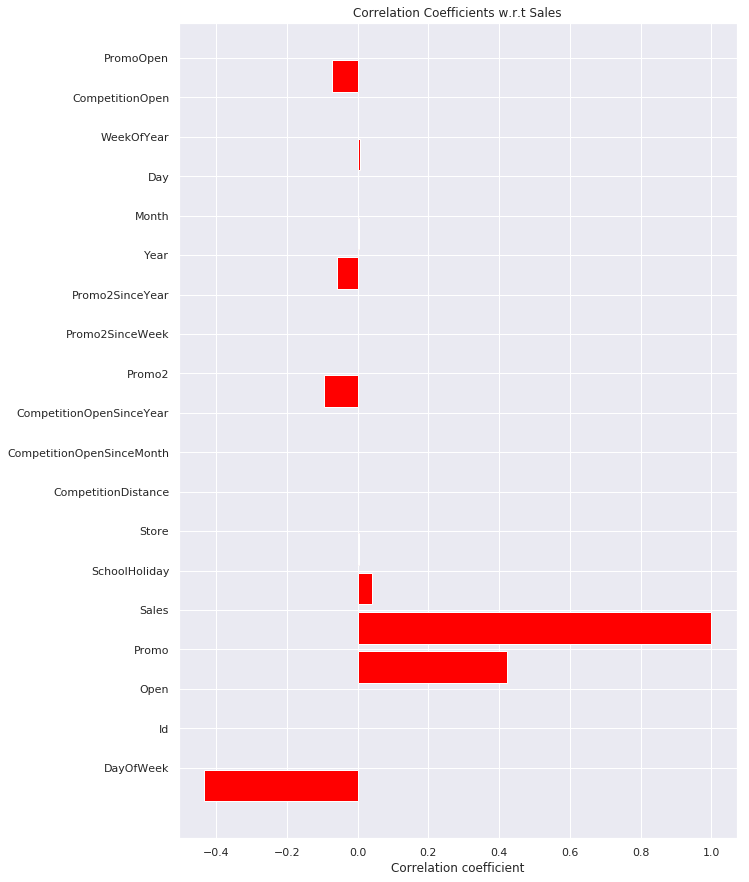

In [29]:
# Plotting correlations
num_feat=df_full.columns[df_full.dtypes!=object]
num_feat=num_feat[1:-1] 
labels = []
values = []
for col in num_feat:
    labels.append(col)
    values.append(np.corrcoef(df_full[col].values, df_full['Sales'].values)[0,1])
    
ind = np.arange(len(labels))
width = 0.9
fig, ax = plt.subplots(figsize=(10,15))
rects = ax.barh(ind, np.array(values), color='red')
ax.set_yticks(ind+((width)/2.))
ax.set_yticklabels(labels, rotation='horizontal')
ax.set_xlabel("Correlation coefficient")
ax.set_title("Correlation Coefficients w.r.t Sales")

Text(0.5, 1.0, 'Correlation between features')

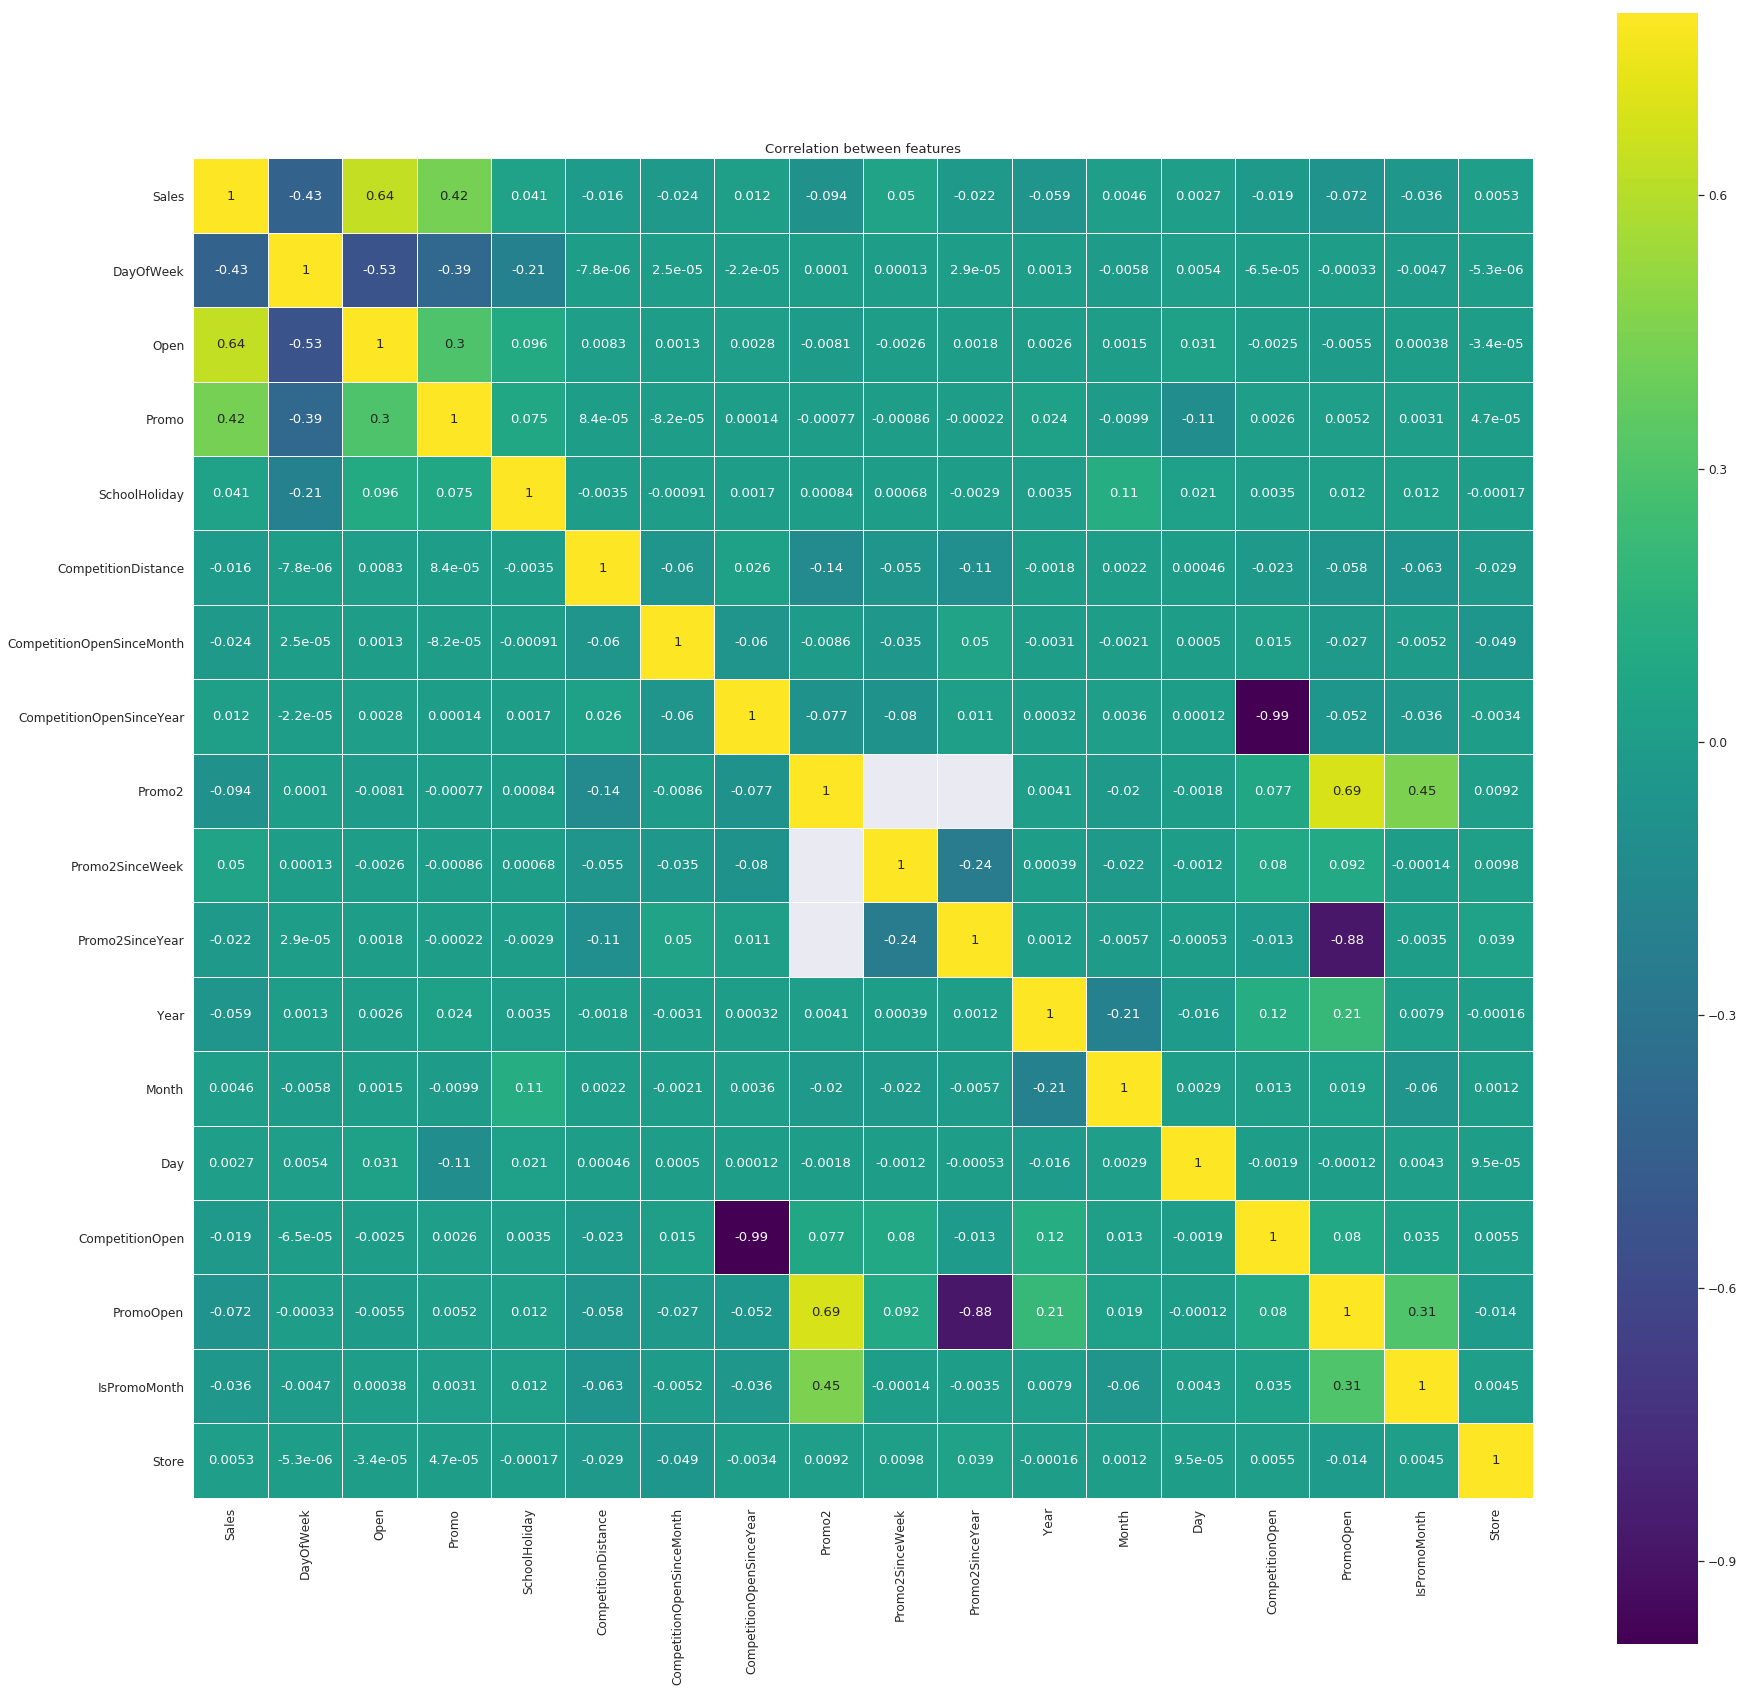

In [30]:
# Heatmap of correlations features
corrMatrix=df_full[["Sales", "DayOfWeek", "Open", "Promo", "SchoolHoliday", "CompetitionDistance",
                    "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2",
                    "Promo2SinceWeek", "Promo2SinceYear", "Year", "Month", "Day",
                    "CompetitionOpen", "PromoOpen", "IsPromoMonth", "Store"]].corr()

sns.set(font_scale=1.10)
plt.figure(figsize=(30, 30))

sns.heatmap(corrMatrix, vmax=.8, linewidths=0.01,
            square=True,annot=True,cmap='viridis',linecolor="white")
plt.title('Correlation between features')

## Functions to create and train the model

In [31]:
def clean_data(use_text_columns = True):
    '''
    Function that clean data and create a new features to enrich the model
    '''
    cols_num = ["Sales", "DayOfWeek", "Open", "Promo", "SchoolHoliday", "CompetitionDistance",
                "CompetitionOpenSinceMonth", "CompetitionOpenSinceYear", "Promo2",
                "Promo2SinceWeek", "Promo2SinceYear", "Wapp", "Avg_Customers", "Year", "Month", "Day",
                "CompetitionOpen", "PromoOpen", "IsPromoMonth", "Store"]

    cols_text = ["StateHoliday", "StoreType", "Assortment"]

    df_train = pd.read_csv('../input/train.csv')    
    len_train_data = len(df_train)

    df_test = pd.read_csv('../input/test.csv')

    # Setting null values of column Open in test dataset
    df_test.loc[df_test['DayOfWeek'] != 7, 'Open'] = 1
    df_test.loc[df_test['DayOfWeek'] == 7, 'Open'] = 0

    avg_customer = sqldf(
      """
      SELECT
      Store,
      DayOfWeek,
      sum(case when Customers is not null then Sales/Customers else 0 end) as Wapp,
      round(avg(Customers)) Avg_Customers
      from df_train
      group by Store,DayOfWeek
      """
    )
    
    df_test = sqldf(
      """
      SELECT
      t.*,
      ac.Wapp,
      ac.Avg_Customers
      from df_test t
      left join avg_customer ac on t.Store = ac.Store and t.DayOfWeek = ac.DayOfWeek
      """
    )
    
    df_train = sqldf(
      """
      SELECT
      t.*,
      ac.Wapp,
      ac.Avg_Customers
      from df_train t
      left join avg_customer ac on t.Store = ac.Store and t.DayOfWeek = ac.DayOfWeek
      """
    )

    # Merge train and test dataset
    all_data = pd.concat([df_train, df_test], ignore_index=True)

    df_extra = pd.read_csv('../input/store.csv')
    df_full = pd.concat([df_train, df_test]).reset_index(drop=True)

    # Merge extra information about stores
    all_data = df_full.merge(df_extra, left_on=['Store'], right_on=['Store'], how='left')

    # Separate date in Year, Month and Day
    all_data.loc[all_data['StateHoliday'] == 0, 'StateHoliday'] = 'd'
    all_data['Year'] = pd.DatetimeIndex(all_data['Date']).year
    all_data['Month'] = pd.DatetimeIndex(all_data['Date']).month
    all_data['Day'] = pd.DatetimeIndex(all_data['Date']).day
    all_data['WeekOfYear'] = pd.DatetimeIndex(all_data['Date']).weekofyear

    # Calculate competition open in months
    all_data['CompetitionOpen'] = 12 * (all_data.Year - all_data.CompetitionOpenSinceYear) + \
        (all_data.Month - all_data.CompetitionOpenSinceMonth)

    # Calculate promo open time in months
    all_data['PromoOpen'] = 12 * (all_data.Year - all_data.Promo2SinceYear) + \
        (all_data.WeekOfYear - all_data.Promo2SinceWeek) / 4.0
    all_data['PromoOpen'] = all_data.PromoOpen.apply(lambda x: x if x > 0 else 0)
    all_data.loc[all_data.Promo2SinceYear == 0, 'PromoOpen'] = 0
    
    # Transform month interval in a boolean column 
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    all_data['monthStr'] = all_data.Month.map(month2str)
    all_data.loc[all_data.PromoInterval == 0, 'PromoInterval'] = ''
    all_data['IsPromoMonth'] = 0
    for interval in all_data.PromoInterval.unique():
        interval = str(interval)
        if interval != '':
            for month in interval.split(','):
                all_data.loc[(all_data.monthStr == month) & (all_data.PromoInterval == interval), 'IsPromoMonth'] = 1

    data_numeric = all_data[cols_num]
    
    # Fill NAN values
    # Only column CompetitionDistance is fill NaN with a median value
    data_numeric['CompetitionDistance'].fillna(data_numeric['CompetitionDistance'].median(), inplace = True)

    # Other values is fill with zero
    data_numeric.fillna(0, inplace = True)

    if (use_text_columns):
        data_text = all_data[cols_text]
        data_text = pd.get_dummies(data_text, dummy_na=False)

        complete_data = pd.concat([data_numeric, data_text], axis = 1)

        df_train = complete_data.iloc[:len_train_data,:]
        df_test = complete_data.iloc[len_train_data:,:]
    else:
        df_train = data_numeric.iloc[:len_train_data,:]
        df_test = data_numeric.iloc[len_train_data:,:]

    return df_train, df_test

In [32]:
def load_train_data(scaler_x, scaler_y):
    '''
    Transform train data set and separate a test dataset to validate the model in the end of training and normalize data
    '''
    X_train = train.drop(["Sales"], axis=1) # Features
    y_train = np.array(train["Sales"]).reshape((len(X_train), 1)) # Targets
    X_train = scaler_x.fit_transform(X_train)
    y_train = scaler_y.fit_transform(y_train)

    X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

    return (X_train, y_train), (X_test, y_test)

In [33]:
def load_test_data():
    '''
    Remove column of predictions and normalize data of submission test data set.
    '''
    X_test = test.drop(["Sales"], axis=1) # Features
    X_test = StandardScaler().fit_transform(X_test)

    return X_test

In [34]:
# Show info of model
def show_info(model, X, y, log, weights = None):
    '''
    Show metrics about the evaluation model and plots about loss, rmse and rmspe
    '''
    if (log != None):
        # summarize history for loss
        plt.figure(figsize=(14,10))
        plt.plot(log.history['loss'])
        plt.plot(log.history['val_loss'])
        plt.title('Model Loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        print('\n')
        
        # summarize history for rmse
        plt.figure(figsize=(14,10))
        plt.plot(log.history['rmse'])
        plt.plot(log.history['val_rmse'])
        plt.title('Model RMSE')
        plt.ylabel('rmse')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()
        print('\n')
        
        # summarize history for rmspe
        plt.figure(figsize=(14,10))
        plt.plot(log.history['rmspe'])
        plt.plot(log.history['val_rmspe'])
        plt.title('Model RMSPE')
        plt.ylabel('rmspe')
        plt.xlabel('epoch')
        plt.legend(['train', 'test'], loc='upper left')
        plt.show()

    if (weights != None):
        model.load_weights(weights)

    predictions = model.predict(X, verbose=1)

    mse = mean_squared_error(y, predictions)
    rmse = sqrt(mse)
    rmspe = rmspe_val(y, predictions)

    print('MSE: %.3f' % mse)
    print('RMSE: %.3f' % rmse)
    print('RMSPE: %.3f' % rmspe)

## RMSPE Formula
$\textrm{RMSPE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} \left(\frac{y_i - \hat{y}_i}{y_i}\right)^2}$

In [35]:
def rmspe_val(y_true, y_pred):
    '''
    RMSPE calculus to validate evaluation metric about the model
    '''
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true), axis=0))[0]

In [36]:
def rmspe(y_true, y_pred):
    '''
    RMSPE calculus to use during training phase
    '''
    return K.sqrt(K.mean(K.square((y_true - y_pred) / y_true), axis=-1))

In [37]:
def rmse(y_true, y_pred):
    '''
    RMSE calculus to use during training phase
    '''
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [38]:
def create_model():
    '''
    Create a neural network
    '''
    initializer = RandomNormal(mean=0.0, stddev=0.05, seed=None)

    model = Sequential()
    model.add(Dense(512, input_dim=X_train.shape[1], activation="relu", kernel_initializer=initializer))
    model.add(Dropout(0.4))
    model.add(Dense(512, input_dim=X_train.shape[1], activation="relu", kernel_initializer=initializer))
    model.add(Dropout(0.4))
    model.add(Dense(512, input_dim=X_train.shape[1], activation="relu", kernel_initializer=initializer))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation="linear", kernel_initializer=initializer))
    adam = Adam(lr=1e-3, decay=1e-3)

    # Compile model
    model.compile(loss="mean_squared_error", optimizer=adam, metrics=[rmse, rmspe])

    return model

In [39]:
train, test = clean_data(use_text_columns = True)

In [40]:
train.head()

,Sales,DayOfWeek,Open,Promo,SchoolHoliday,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,Wapp,Avg_Customers,Year,Month,Day,CompetitionOpen,PromoOpen,IsPromoMonth,Store,StateHoliday_0,StateHoliday_a,StateHoliday_b,StateHoliday_c,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c
0,5263.0,5,1.0,1,1,1270.0,9.0,2008.0,0,0.0,0.0,1012.0,537.0,2015,7,31,82.0,0.00,0,1,1,0,0,0,0,0,1,0,1,0,0
1,6064.0,5,1.0,1,1,570.0,11.0,2007.0,1,13.0,2010.0,1013.0,537.0,2015,7,31,92.0,64.50,1,2,1,0,0,0,1,0,0,0,1,0,0
2,8314.0,5,1.0,1,1,14130.0,12.0,2006.0,1,14.0,2011.0,1098.0,747.0,2015,7,31,103.0,52.25,1,3,1,0,0,0,1,0,0,0,1,0,0
3,13995.0,5,1.0,1,1,620.0,9.0,2009.0,0,0.0,0.0,870.0,1245.0,2015,7,31,70.0,0.00,0,4,1,0,0,0,0,0,1,0,0,0,1
4,4822.0,5,1.0,1,1,29910.0,4.0,2015.0,0,0.0,0.0,1022.0,540.0,2015,7,31,3.0,0.00,0,5,1,0,0,0,1,0,0,0,1,0,0


In [41]:
# Hyperparameters and load data to train the model
batch_size = 512
nb_epoch = 300

scaler_x = StandardScaler()
scaler_y = StandardScaler()

print('Loading data...')
(X_train, y_train), (X_test, y_test) = load_train_data(scaler_x, scaler_y)

print('Build model...')
model = create_model()
model.summary()

Loading data...
Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 512)               15872     
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_6 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)       

In [42]:
print('Fit model...')
filepath="weights_rossmann.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
callbacks_list = [checkpoint, early_stopping]

log = model.fit(X_train, y_train,
          validation_split=0.20, batch_size=batch_size, epochs=nb_epoch, shuffle=True, callbacks=callbacks_list)

Fit model...
Train on 651013 samples, validate on 162754 samples
Epoch 1/300
651013/651013 [==============================] - 5s 8us/step - loss: 0.1251 - rmse: 0.3489 - rmspe: 2.4327 - val_loss: 0.1414 - val_rmse: 0.3752 - val_rmspe: 1.6632

Epoch 00001: val_loss improved from inf to 0.14141, saving model to weights_rossmann.best.hdf5
Epoch 2/300
651013/651013 [==============================] - 5s 7us/step - loss: 0.0929 - rmse: 0.3038 - rmspe: 2.2179 - val_loss: 0.1516 - val_rmse: 0.3886 - val_rmspe: 1.5536

Epoch 00002: val_loss did not improve from 0.14141
Epoch 3/300
651013/651013 [==============================] - 5s 8us/step - loss: 0.0842 - rmse: 0.2893 - rmspe: 2.1481 - val_loss: 0.1434 - val_rmse: 0.3779 - val_rmspe: 1.5142

Epoch 00003: val_loss did not improve from 0.14141
Epoch 4/300
651013/651013 [==============================] - 5s 8us/step - loss: 0.0794 - rmse: 0.2810 - rmspe: 2.0501 - val_loss: 0.1278 - val_rmse: 0.3568 - val_rmspe: 1.5034

Epoch 00004: val_loss impr

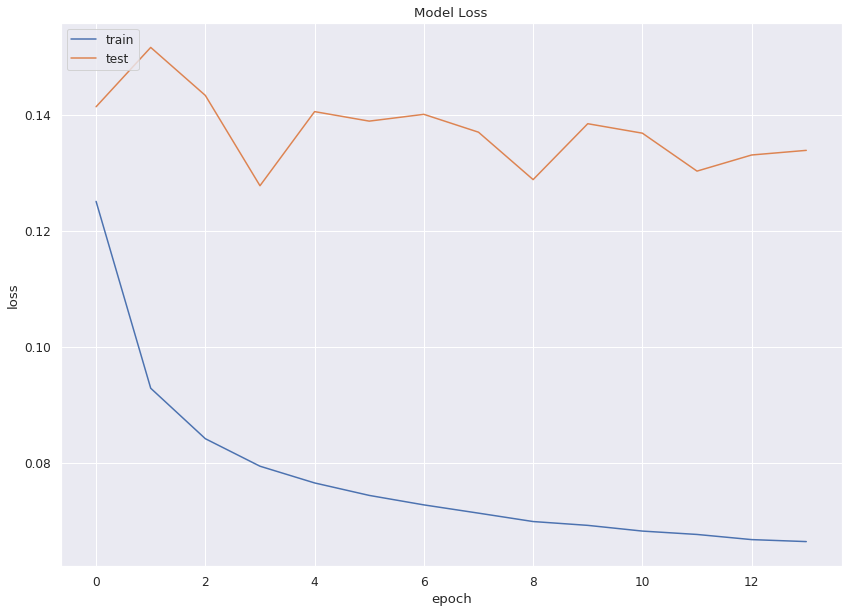

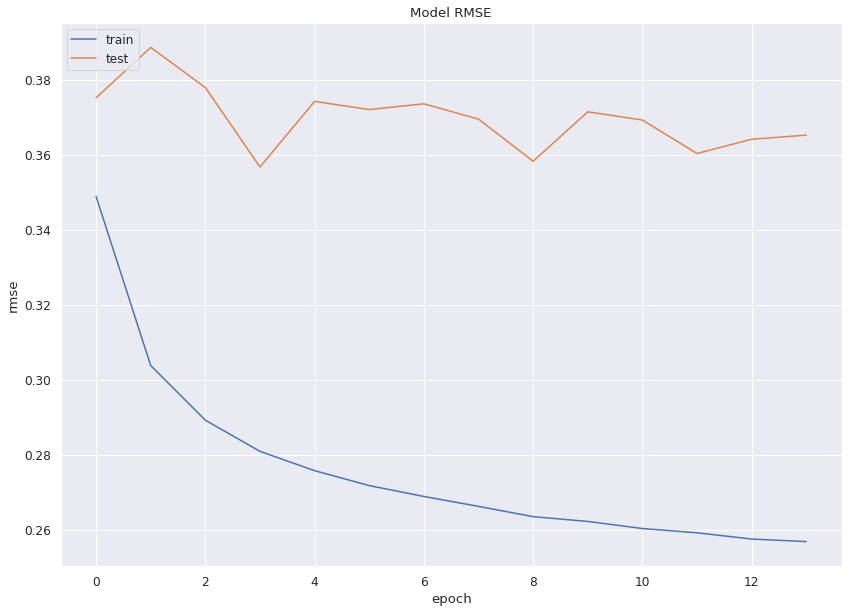

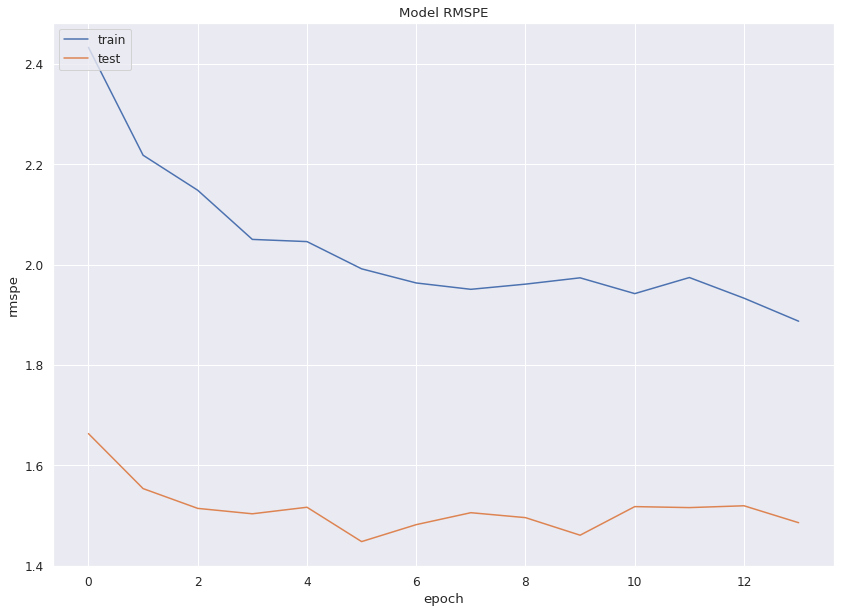

203442/203442 [==============================] - 5s 23us/step
MSE: 0.128
RMSE: 0.358
RMSPE: 29.893


In [43]:
show_info(model, X_test, y_test, log, weights='weights_rossmann.best.hdf5')

In [44]:
test_data = load_test_data()

df_teste = pd.read_csv('../input/test.csv')

In [45]:
predict = model.predict(test_data)
predict = scaler_y.inverse_transform(predict)

In [46]:
submission = pd.DataFrame()
submission['Id'] = df_teste["Id"]
submission['Sales'] = predict

submission.to_csv('submission.csv', index=False)